Baseline Model - Multi Class Logistic Regression
===
I started by fitting a multi-class logistic regression on the data, which is served as a baseline model before exploring more options. The logistic regression baseline model will give me a general idea of how the dataset can help to label the transactions and what are the potential issues.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from pymongo import MongoClient

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiahe_000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

As usual, I extract data from my local MongoDB instance with the help of pymongo library. I extracted amount, data, name and category into a pandas dataframe as a start point. See below for a few lines of the data.

In [41]:
mongoclient = MongoClient('localhost')
##Mongoclient.database_names()
db = mongoclient['bankdata']

##Get name, amount, date
transactions = pd.DataFrame(list(db.transactions.find({},{"name":1,"amount":1,"date":1,"category":1})))
transactions.head(5)

,_id,amount,category,date,name
0,5a654374671a0b45285f30de,14.15,Food and Drink,2018-01-19,MR BING VANDERBILT LL
1,5a654374671a0b45285f30df,18.00,Transfer,2018-01-19,QuickPay with Zelle payment to John Sheu 68370...
2,5a654374671a0b45285f30e0,50.00,Shops,2018-01-17,Sephora
3,5a654374671a0b45285f30e1,40.00,Transfer,2018-01-16,ATM WITHDRAWAL 007235 01/16530 5TH A
4,5a654374671a0b45285f30e2,404.98,Service,2018-01-16,Nissan Auto Loan 0010248429968 WEB ID: 9782464003


Feature Engineering with bag of words
---
To fast prototype my baseline model, I choose to use a common approach in text analytics 'bag of words' to transform the transaction name into a vector of word count.

**Data cleaning:** a function 'name_to_words' is defined to clean up the data. It does three things: a) remove numbers in the transaction name text, as they don't contain much prediction power. For example in name 'ATM WITHDRAWAL 007235 01/16530 5TH A', the number '007235' can be assumed to be noises in the data; b) remove stop words; c) convert all letters into lower case.

In [5]:
def name_to_words( raw_name ):
    # Function to convert a raw name to a string of words
    # The input is a single string (a raw transaction name), and 
    # the output is a single string (a preprocessed transaction name)
    #
    # Remove non-letters        
    ##letters_only = re.sub("[^a-zA-Z]", " ", raw_name)
    letters_only = re.sub("\S*\d\S*", "", raw_name)
    # Convert to lower case
    words = letters_only.lower().split()        
    
    stops = set(stopwords.words("english"))                  
    # 
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

Here is a example of applying 'name_to_word' function to a transaction name. Note that how the text is clean up after applying the function.

In [104]:
name_to_words("ATM WITHDRAWAL 007235 01/16530 5TH A")

'atm withdrawal'

In [42]:
num_trans = transactions["name"].size

# Initialize an empty list to hold the clean reviews
clean_name = []

for i in xrange( 0, num_trans ):
    # Call our function for each one, and add the result to the list of clean names
    clean_name.append( name_to_words( transactions["name"][i] ) )

transactions['clean_name'] = clean_name

**Bag-of-words model:** Now I convert the cleaned version of transaction name into a numberical vector, with the help of 'CountVectorizer' from sklean library.

In [43]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             ) 
bow_features = vectorizer.fit_transform(clean_name)

vocab = vectorizer.get_feature_names()
bow_features = pd.DataFrame(bow_features.toarray())
bow_features.columns = vocab

Multi Class Logistic Regression- One vs rest 
---
**Split data into training set and testing set:** I randomly select 50% of the records as traning data, and the rest to be the testing data.

In [45]:
np.random.seed(0)
num_trans = transactions["_id"].size
split_list = np.random.uniform(0,1,num_trans)
p=0.5
train_x = bow_features[split_list < p]
test_x = bow_features[split_list >= p]
train_y = transactions["category"][split_list < p]
test_y = transactions["category"][split_list >= p]

print train_x.shape
print train_y.shape

print test_x.shape
print test_y.shape

(790, 562)
(790L,)
(784, 562)
(784L,)


**Logistic regression**: I used both 'One vs rest' and 'One vs one' classifier. It turned out that logistic regression performs very well on the test set. The 'One vs rest' model achieved an overall accuracy level of 91%, which is slightly higher than the 'One vs one accuracy' model.

In [46]:
OVR = OneVsRestClassifier(LogisticRegression()).fit(train_x,train_y)
OVO = OneVsOneClassifier(LogisticRegression()).fit(train_x,train_y)
print 'One vs rest accuracy: %.3f' % OVR.score(test_x,test_y)
print 'One vs one accuracy: %.3f' % OVO.score(test_x,test_y)

One vs rest accuracy: 0.912
One vs one accuracy: 0.904


Interpret the result of Logistic Regression
---

Now let's take a look of the missclassified transactions. The model seems tend to classify the transaction to 'Food and Drink' or 'Shops'. For example it missclassifies the transaction 'udemy online courses' to 'Shops', which it should really be 'Education'. The marginal probability(One vs rest) of the class 'Shops' is 20.8%, which is the highest among all classes. The probability for 'Education' is 11.3%. Note that 'Food and Drink' has a probability of 15%.

This kind of behaviour is not a big surprise because 'Food and Drink' and 'Shops' are the most frequent transaction class in our traning set, so this might be a result of unbalanced data

In [185]:
predictions = OVR.predict(test_x)
prob = pd.DataFrame(OVR.predict_proba(test_x),columns = OVR.classes_)

test = transactions[["_id","clean_name","category"]][split_list >= p]
test["predicted_category"] = predictions
##test_result = pd.concat([test, prob], axis=1)
test.index = pd.RangeIndex(len(test.index))
test_result = test.merge(prob, left_index=True, right_index=True)

test_error = test_result[test['predicted_category'] != test['category']]
test_error.head(5)
##test_error.to_clipboard()

,_id,clean_name,category,predicted_category,Bank Fees,Education,Food and Drink,Grocery,Healthcare,Interest,Payment,Payroll,Recreation,Service,Shops,Transfer,Travel
2,5a654374671a0b45285f30e0,sephora,Shops,Food and Drink,0.014770,0.033324,0.308341,0.074088,0.026964,0.018875,0.032242,0.019066,0.030791,0.056253,0.184577,0.068889,0.131820
7,5a654374671a0b45285f30e8,udemy online courses,Education,Shops,0.014960,0.113926,0.150785,0.051892,0.024122,0.015483,0.060869,0.104393,0.026755,0.035936,0.207516,0.116557,0.076806
14,5a654374671a0b45285f30f2,annual membership fee,Bank Fees,Food and Drink,0.183565,0.032661,0.219493,0.067044,0.026820,0.019152,0.031678,0.019335,0.030354,0.052570,0.144774,0.062904,0.109649
17,5a654374671a0b45285f30f7,papyrus world trade c,Shops,Food and Drink,0.014770,0.033324,0.308341,0.074088,0.026964,0.018875,0.032242,0.019066,0.030791,0.056253,0.184577,0.068889,0.131820
21,5a654374671a0b45285f30ff,,Travel,Food and Drink,0.014770,0.033324,0.308341,0.074088,0.026964,0.018875,0.032242,0.019066,0.030791,0.056253,0.184577,0.068889,0.131820


The above table shows the some examples of missclassification. It also include the marginal probability for each class. As mentioned above, the model tend to predict uncertain transactions into 'Food and Drink', which can be a result of unblanced data. Note that out of 69 missclassified transactions, 50 of them are classified as 'Food and Drink' !

**Visualize the result:**

In [190]:
summary_tbl = pd.pivot_table(test, values ='_id', index='category',columns='predicted_category', aggfunc='count', fill_value=0)
summary_tbl.insert(0, column = 'Bank Fees', value = 0)
summary_tbl.insert(8, column = 'Recreation', value = 0)
summary_tbl.insert(11, column = 'Tax', value = 0)
summary_tbl

predicted_category,Bank Fees,Education,Food and Drink,Grocery,Healthcare,Interest,Payment,Payroll,Recreation,Service,Shops,Tax,Transfer,Travel
category,,,,,,,,,,,,,,
Bank Fees,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Education,0,13,1,0,0,0,0,0,0,0,2,0,0,1
Food and Drink,0,0,201,0,0,0,0,0,0,1,1,0,0,1
Grocery,0,0,0,54,0,0,0,0,0,0,0,0,0,0
Healthcare,0,0,6,0,2,0,0,0,0,0,1,0,0,0
Interest,0,0,0,0,0,36,0,0,0,0,0,0,0,0
Payment,0,0,0,0,0,0,80,0,0,0,0,0,0,0
Payroll,0,0,0,0,0,0,0,75,0,0,0,0,0,0
Recreation,0,0,6,0,0,0,0,0,0,0,2,0,0,1


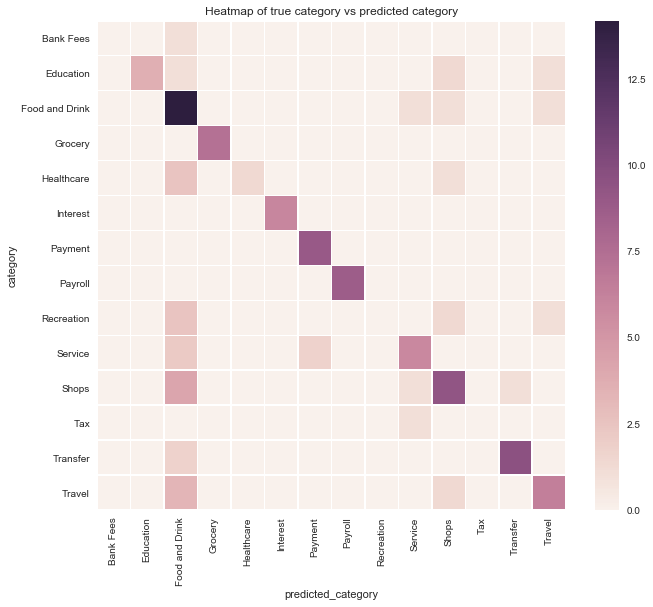

In [189]:
fig = plt.figure(figsize=(10.5,9))
r = sns.heatmap(np.sqrt(summary_tbl), linewidths=.5)
r.set_title("Heatmap of true category vs predicted category")

The model does a very good job to classify 'Interest','Payment','Payroll','Grocery' and 'Transfer' transactions. For 'Bank Fees' and 'Tax' transactions, the model seems have some difficulties to make the right decision, which is understandable given that we really don't have much available data in these two classes to train the model (see last section for more details). The model is doing a fine job to label 'Education','Service','Shops'and 'Travel', with missclassification mainly scattered in other categories, mainly in 'Food and Drink'. Also note the it did very bad in 'Recreation', unfortunately, none the 'Recreation' transactions are classified correctly.

**Precision and Recall**